In [ ]:
%pip install matplotlib
%pip install seaborn

In [ ]:
%pip install sentence_transformers

In [5]:
import aiohttp
import asyncio


async def fetch_api( age, gene_fault, llm, category, patient_question):
    async with aiohttp.ClientSession() as session:
        link = "http://127.0.0.1:8000/chat"
        payload = {
                "age" : age,
                "gene_fault": gene_fault,
                "llm": llm,
                "category": category,
                "patient_question": patient_question
            }
        resp = await session.post( link, json=payload  )
        
        try:
            data = await resp.json()
            # print("Response JSON:", data)
            return data
        except aiohttp.ContentTypeError:
            text = await resp.text()
            # print("Response Text:", text)
            return text
        

In [6]:
mistral = await fetch_api( 50, "BRCA1", "mistral", "breast_cancer", "What is the best treatment for me?" )
deepseek = await fetch_api( 50, "BRCA1", "deepseek", "breast_cancer", "What is the best treatment for me?" )
openai = await fetch_api( 50, "BRCA1", "openai", "breast_cancer", "What is the best treatment for me?" )


In [33]:
import json
with open("mistral_response.json", "w", encoding="utf-8") as f:
    json.dump(mistral, f, indent=2, ensure_ascii=False)
    
with open("deepseek_response.json", "w", encoding="utf-8") as f:
    json.dump(deepseek, f, indent=2, ensure_ascii=False)
    
with open("openai_response.json", "w", encoding="utf-8") as f:
    json.dump(openai, f, indent=2, ensure_ascii=False)

In [28]:
def llm_response( path ):
    with open(path, "r", encoding="utf-8") as f:
        data = json.load(f)
    return data

In [35]:
mistra_path = "mistral_response.json"
mistra_res_json = llm_response(mistra_path)

deepseek_path = "deepseek_response.json"
deepseek_res_json = llm_response(deepseek_path)

opeai_path = "openai_response.json"
openai_res_json = llm_response(opeai_path)
            


In [37]:
openai_res_json

{'output': 'For someone who is 30 years old and has a BRCA2 gene fault, the risk of developing breast cancer between ages 25 and 30 is approximately 1-2%. The risk of ovarian cancer by this age is generally low but tends to increase after age 40. Other cancers associated with BRCA2 mutations, such as male breast cancer, prostate cancer, and pancreatic cancer, typically have risks that become more relevant at older ages beyond 30.  \n\nWhile the risk of breast cancer at your current age is relatively low, it is not zero, so regular surveillance and discussions about risk management with healthcare professionals or a genetic counselor are recommended. This can help ensure early detection and preventive measures if necessary.  \n\nIf you have further concerns or want tailored advice, seeking guidance from a genetic counselor or specialist is strongly advised.  \n\nHeading: Resources  \n- Detailed, age-specific risk data and management guidelines are often provided by genetic counseling se

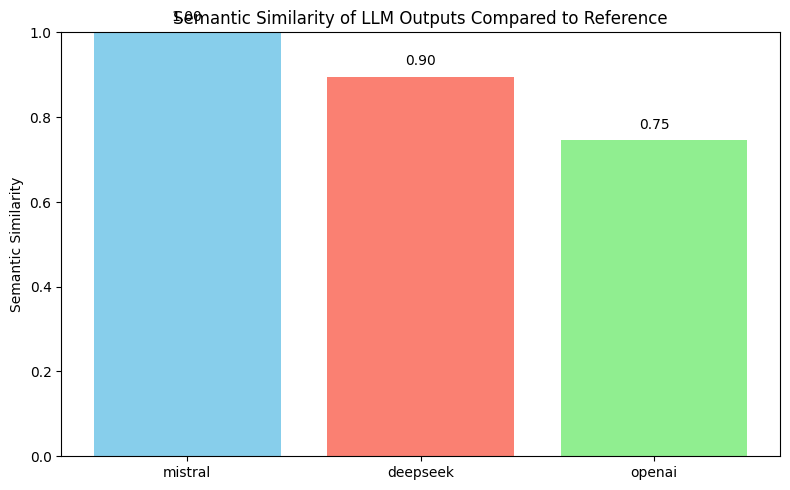

In [38]:
from sentence_transformers import SentenceTransformer, util
import matplotlib.pyplot as plt

# Load a BERT-based model
model = SentenceTransformer('all-MiniLM-L6-v2')  # Lightweight, fast BERT variant

# Reference answer and LLM outputs
reference_text = mistra_res_json["output"]
llm_outputs = {
    "mistral":  mistra_res_json["output"],
    "deepseek": deepseek_res_json["output"],
    "openai":   openai_res_json["output"]
}

# Create a list of texts: [reference, llm_1, llm_2, ...]
texts = [reference_text] + list(llm_outputs.values())

# Get BERT embeddings
embeddings = model.encode(texts, convert_to_tensor=True)

# Compute cosine similarities between reference and each LLM output
similarities = {
    name: util.cos_sim(embeddings[0], embeddings[i + 1]).item()
    for i, name in enumerate(llm_outputs)
}

# Plotting
plt.figure(figsize=(8, 5))
bars = plt.bar(similarities.keys(), similarities.values(), color=['skyblue', 'salmon', 'lightgreen'])
plt.ylim(0, 1)
plt.ylabel("Semantic Similarity")
plt.title("Semantic Similarity of LLM Outputs Compared to Reference")

# Annotate bars with values
for bar in bars:
    score = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, score + 0.02, f"{score:.2f}", ha='center', va='bottom')

plt.tight_layout()
plt.show()


In [6]:
%pip install pandas

Note: you may need to restart the kernel to use updated packages.


In [10]:
import pandas as pd

data = pd.DataFrame([
    {"Model": "GPT-4", "Question": "What is climate change?", "Response": "Climate change is the long-term change in global climate patterns."},
    {"Model": "Claude", "Question": "What is climate change?", "Response": "It refers to long-term shifts in weather and climate patterns."},
    {"Model": "GPT-4", "Question": "Define photosynthesis", "Response": "Photosynthesis is the process by which plants make food using sunlight."},
    {"Model": "Claude", "Question": "Define photosynthesis", "Response": "It is a process where plants convert sunlight into energy."},
])

reference_answers = {
    "What is climate change?": "Climate change refers to significant long-term changes in global weather patterns due to human activities.",
    "Define photosynthesis": "Photosynthesis is the process where green plants use sunlight to synthesize foods from carbon dioxide and water."
}



In [18]:
from sentence_transformers import SentenceTransformer, util

model = SentenceTransformer('all-MiniLM-L6-v2')

def compute_similarity(row):
    reference = reference_answers[row["Question"]]
    embeddings = model.encode([row["Response"], reference], convert_to_tensor=True)
    score = util.cos_sim(embeddings[0], embeddings[1])
    return score.item()

data["SemanticSimilarity"] = data.apply(compute_similarity, axis=1)


In [19]:

by_model = data.groupby("Model")["SemanticSimilarity"].mean()
print("Average similarity by model:")
print(by_model)




Average similarity by model:
Model
Claude    0.777866
GPT-4     0.892032
Name: SemanticSimilarity, dtype: float64


In [20]:
by_model_question = data.groupby(["Model", "Question"])["SemanticSimilarity"].mean().unstack()
print("\nSimilarity by model and question:")
print(by_model_question)



Similarity by model and question:
Question  Define photosynthesis  What is climate change?
Model                                                   
Claude                 0.787665                 0.768067
GPT-4                  0.910352                 0.873712


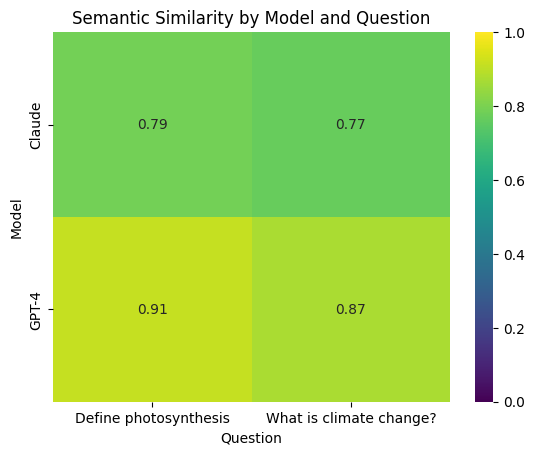

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(by_model_question, annot=True, cmap="viridis", vmin=0, vmax=1)
plt.title("Semantic Similarity by Model and Question")
plt.show()


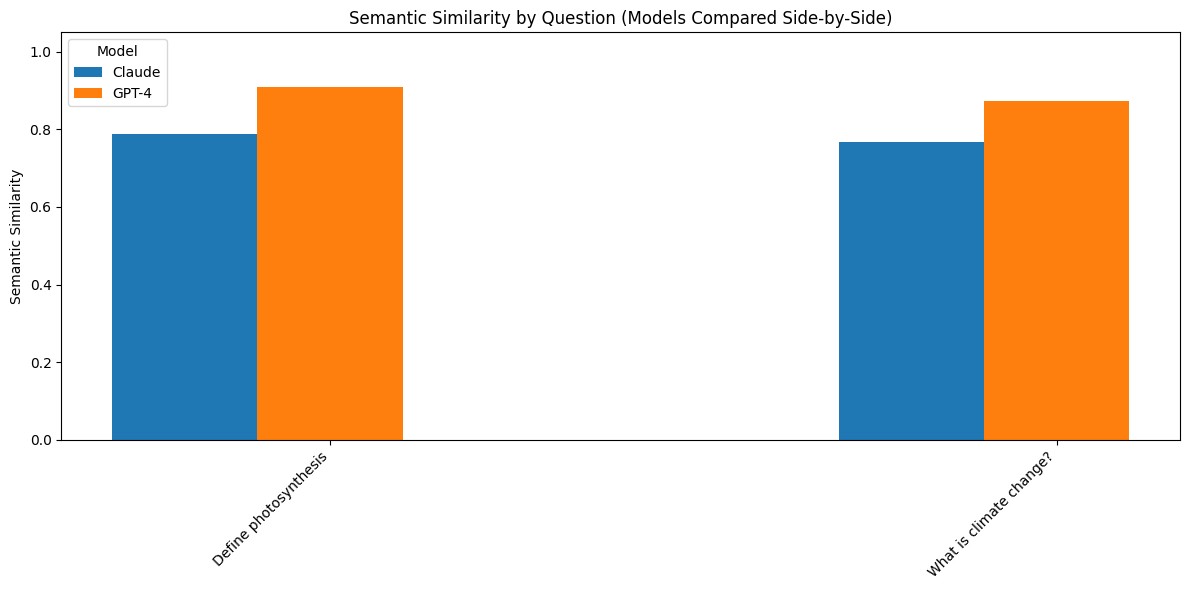

In [26]:
import matplotlib.pyplot as plt
import numpy as np

# Group by Question and Model to get average similarity
grouped = data.groupby(["Question", "Model"])["SemanticSimilarity"].mean().unstack()

# Setup for grouped bars
questions = grouped.index
models = grouped.columns
x = np.arange(len(questions))
width = 0.2  # Width of each bar

# Plot each model's bars side by side
plt.figure(figsize=(12, 6))
for i, model in enumerate(models):
    plt.bar(x + i * width, grouped[model], width=width, label=model)

# Add labels and formatting
plt.xticks(x + width, questions, rotation=45, ha='right')
plt.ylabel("Semantic Similarity")
plt.title("Semantic Similarity by Question (Models Compared Side-by-Side)")
plt.ylim(0, 1.05)
plt.legend(title="Model")
plt.tight_layout()
plt.show()
